In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import sklearn
import seaborn as sb
import pandas as pd
import time
print(sklearn.__version__)

0.21.1


In [2]:
import numpy as np
from numba import jit


@jit(nopython=True)
def im2index(im):
    assert len(im.shape) == 3
    r = im[:, :, 0].ravel()
    g = im[:, :, 1].ravel()
    b = im[:, :, 2].ravel()
    label = np.zeros((r.shape[0], 1), dtype=np.uint8)
    for i in range(r.shape[0]):
        # Unknown
        if r[i] == 0 and g[i] == 0 and b[i] == 0:
            label[i] = 0
        # Forest
        elif r[i] == 0 and g[i] == 255 and b[i] == 255:
            label[i] = 1
        # Built-up
        elif r[i] == 255 and g[i] == 0 and b[i] == 0:
            label[i] = 2
        # Water
        elif r[i] == 0 and g[i] == 0 and b[i] == 255:
            label[i] = 3
        # Farmland
        elif r[i] == 0 and g[i] == 255 and b[i] == 0:
            label[i] = 4
        # Meadow
        elif r[i] == 255 and g[i] == 255 and b[i] == 0:
            label[i] = 5
        else:
            label[i] = 0
    indx_img = np.reshape(label, (-1, im.shape[1]))
    return indx_img

In [3]:
import numpy as np

def confusion_metrics(target, predict, num_of_classes):
    conf_metrics = np.zeros((num_of_classes, num_of_classes), dtype=np.int)
    for h in range(target.shape[0]):
        for w in range(target.shape[1]):
            conf_metrics[target[h,w], predict[h,w]] += 1
    return conf_metrics


def norm_confusion_metrics(conf_matrix):

    '''
    Return a normalize confusion metric.
    Divide each cell of a row by the sum of each row
    '''

    new_cf = np.zeros(conf_matrix.shape, dtype=np.float)
    for i in range(conf_matrix.shape[0]):
        new_cf[i,:] = conf_matrix[i,:] / sum(conf_matrix[i,:])

    for k in range(6):
        for l in range(6):
            if new_cf[k,l] >= 0:
                new_cf[k,l] = new_cf[k,l]
            else:
                new_cf[k,l] = 0

    return new_cf


def get_confusion_metrics_score(class_index, conf_metric):
    '''
        Return an array of tp, fp, fn, tn respectively
    '''
    conf_copy = conf_metric.copy()
    conf_copy[class_index, :] = 0
    conf_copy[:, class_index] = 0

    tp = conf_metric[class_index, class_index]
    fp = sum(conf_metric[:, class_index]) - tp
    fn = sum(conf_metric[class_index, :]) - tp
    tn = sum(sum(conf_copy))
    
    return [tp, fp, fn, tn]


def precision(tp, fp):
    if tp == 0:
        return 1
    elif tp + fp == 0:
        return 1
    else:
        return tp / (tp + fp)

    
def recall(tp, fn):
    if tp == 0:
        return 1
    elif tp + fn == 0:
        return 1
    else:
        return tp / (tp + fn)

    
def accuracy(tp, tn, fp, fn):
    if tp + tn + fp + fn == 0:
        return 1
    else:
        return (tp + tn) / (tp + tn + fp + fn)


def iou_conf(tp, fn, fp):
    if tp + fn + fp == 0:
        return 1
    return tp / (tp + fn + fp)


def iou(target, predict):
    intersection = np.logical_and(target, predict)
    union = np.logical_or(target, predict)
    iou_score = np.sum(intersection) / np.sum(union)
    if iou_score is None:
        print("null")
        return 0
    else:
        return iou_score

def percentage(num_of_classes, target):
    total = target.shape[0] * target.shape[1]
    percentage = np.arange(0, num_of_classes, dtype=np.int)
    
    for i in target.ravel():
        percentage[i] += 1

    return (percentage/total) * 100

In [6]:
# Dhaka
img = '2016-10-23_7201910522.png'

orginal = Image.open(os.path.join('dhaka/org', img))
target = Image.open(os.path.join('dhaka/tar', img))
predict = Image.open(os.path.join('dhaka/pred', img))

In [7]:
org = np.asarray(orginal)
target = np.asarray(target)
predict = np.asarray(predict)

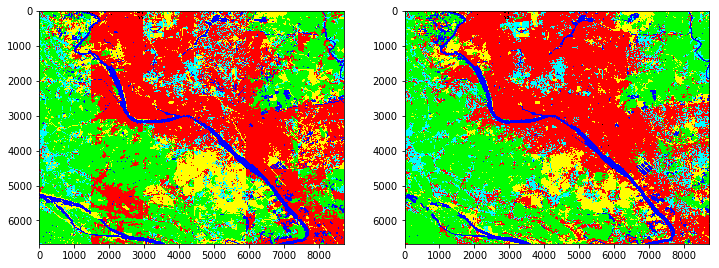

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(target)
plt.subplot(122)
plt.imshow(predict)
plt.show()

In [9]:
start_ms = int(round(time.time() * 1000))

tar_ind = im2index(target)
pre_ind = im2index(predict)

end_ms = int(round(time.time() * 1000))
print(f'Time: {end_ms - start_ms}')

Time: 1034


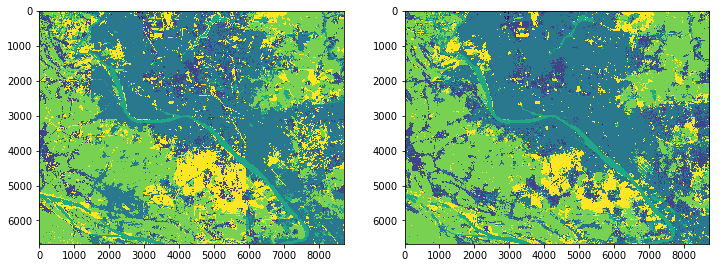

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(tar_ind)
plt.subplot(122)
plt.imshow(pre_ind)
plt.show()

In [11]:
cf = confusion_metrics(target=tar_ind, predict=pre_ind, num_of_classes=6)

In [13]:
print(cf)
normalize_conf_matrix = norm_confusion_metrics(conf_matrix=cf)


'''
This formula is used to normalize data
Formula: Xnorm = (X - Xmin)/(Xmax - Xmin)
'''
# max_conf = np.amax(cf)
# min_conf = np.amin(cf)
# norm_cf = (cf - min_conf)/(max_conf - min_conf)
# print(norm_cf)

[[   27975      153     1567     2268      311      175]
 [     118  2473987  1789339    41584   556419   179166]
 [    1684  2175094 17640153   126822  1472679  1092278]
 [     728   176537   180853  2665790   449906   235335]
 [     566   767870  1106141   162487 14946550  1576486]
 [     589   507311  2470192   285803  1717115  3328318]]


'\nThis formula is used to normalize data\nFormula: Xnorm = (X - Xmin)/(Xmax - Xmin)\n'

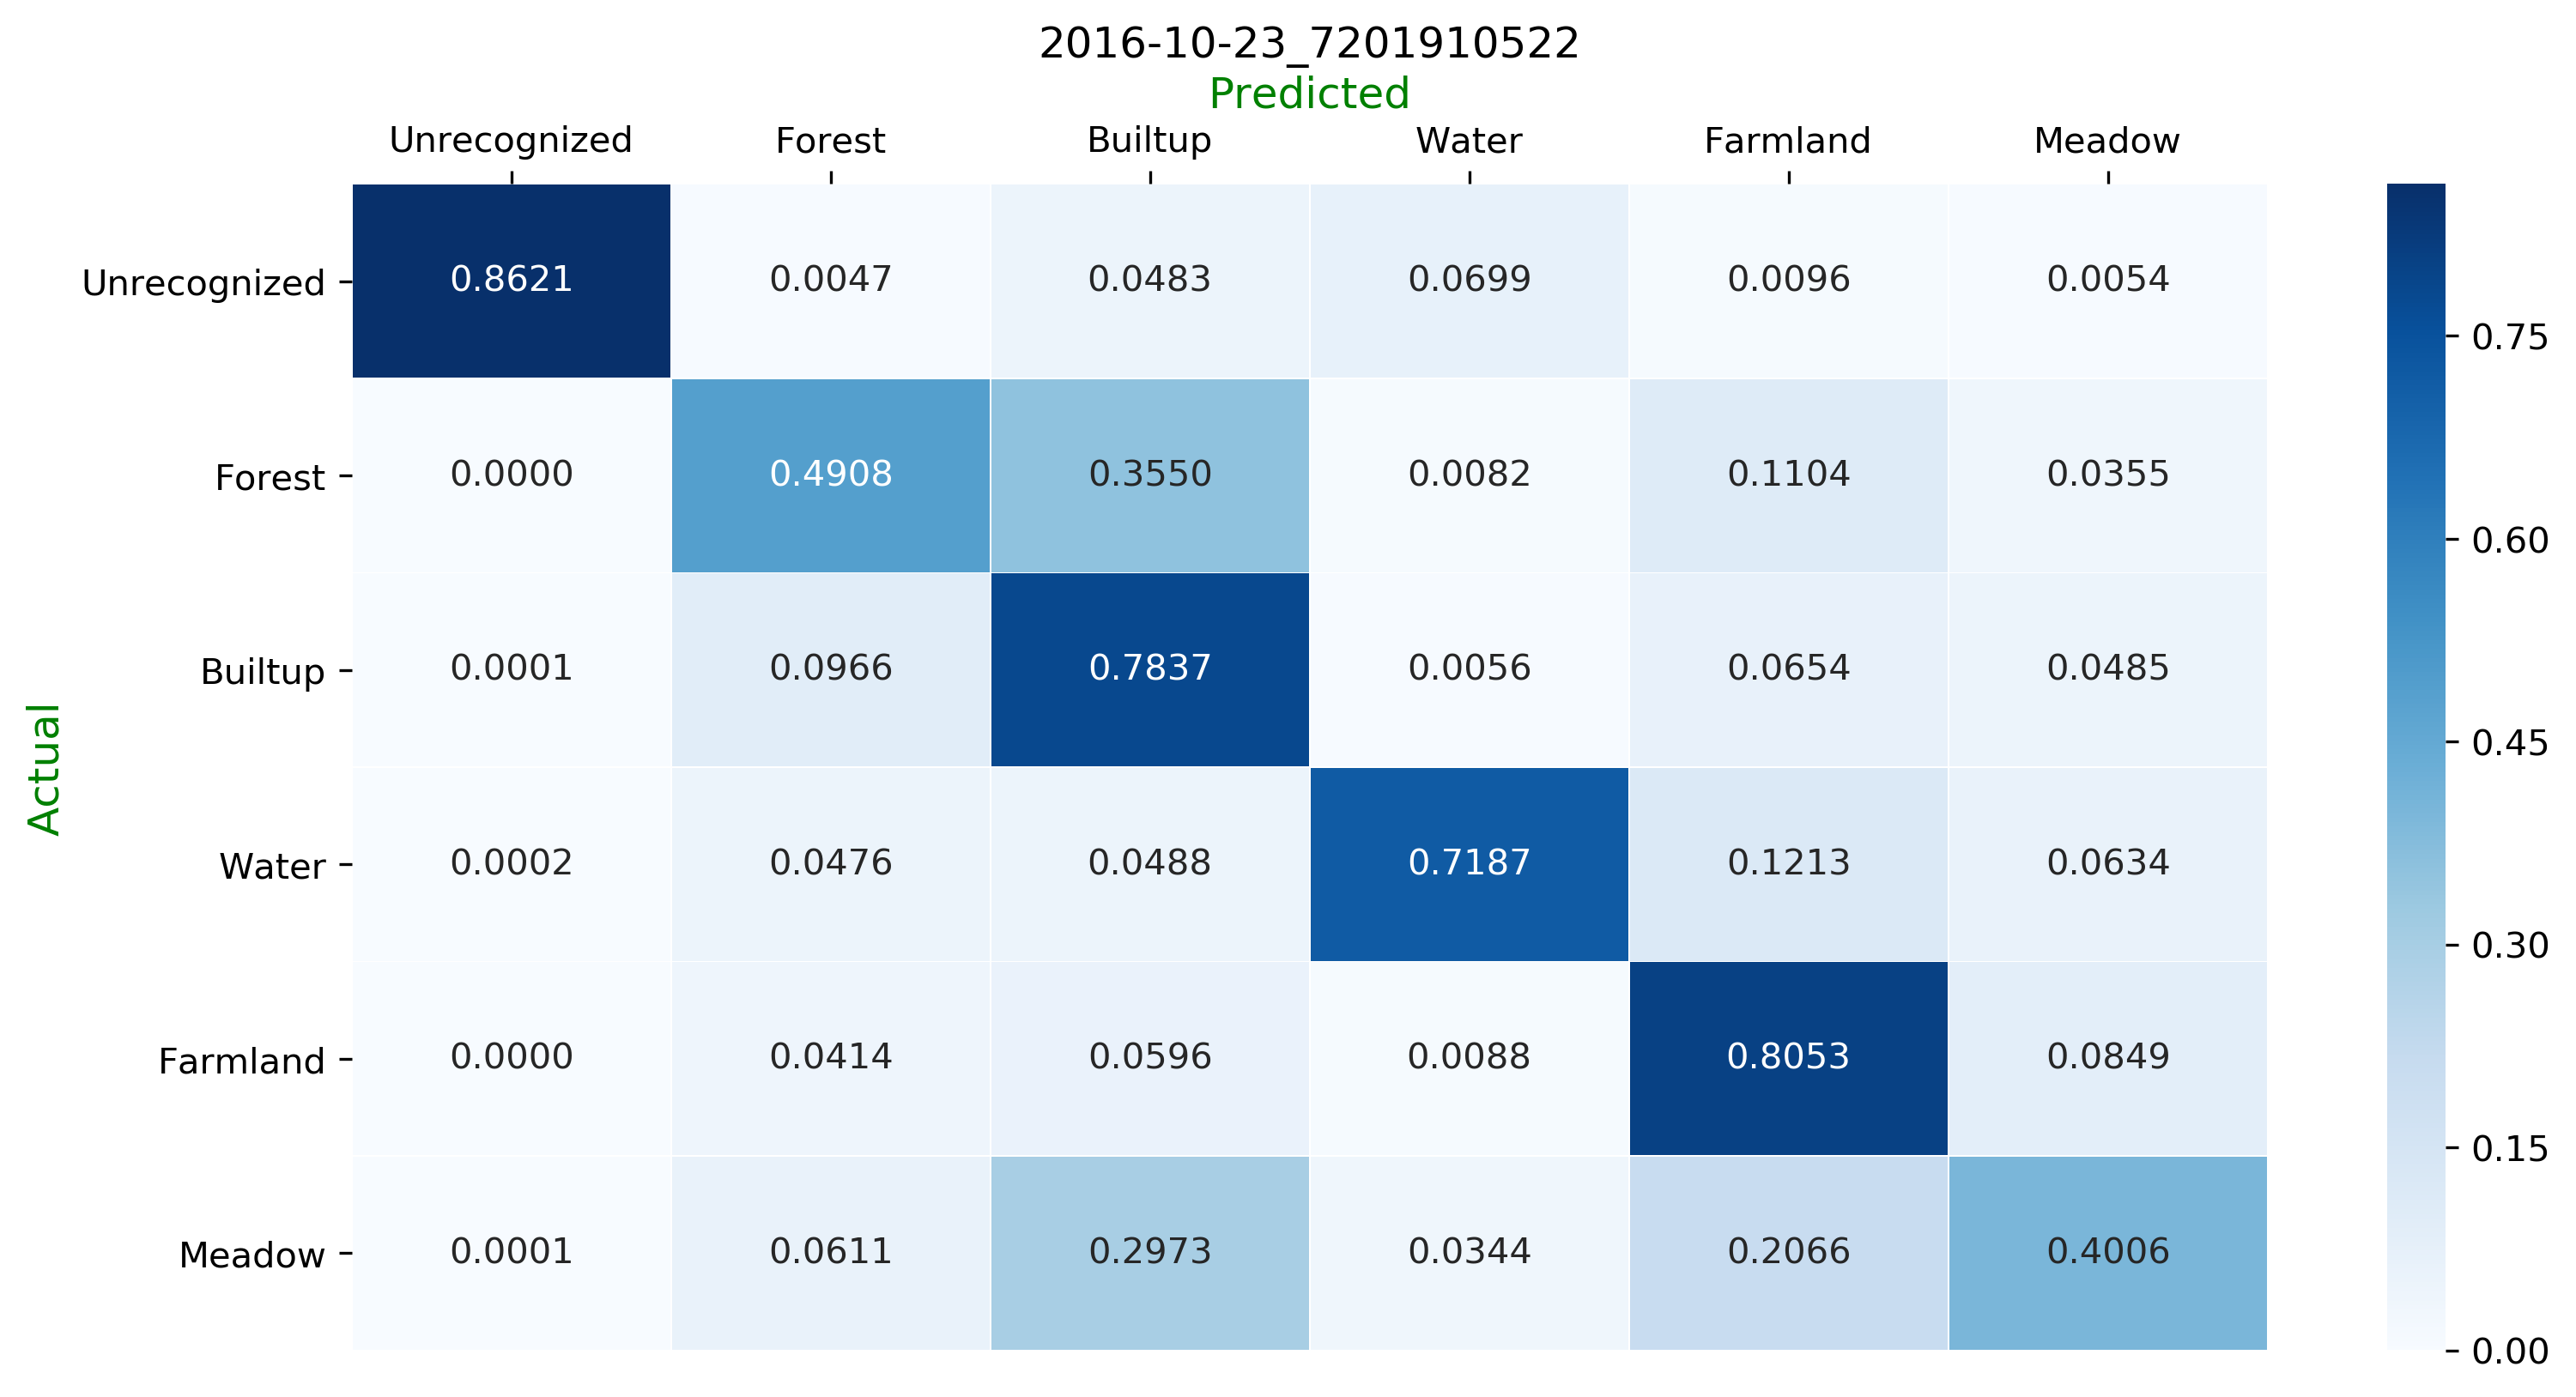

In [14]:
df_cm = pd.DataFrame(normalize_conf_matrix, index = [i for i in ["Unrecognized", "Forest", "Builtup", "Water", "Farmland", "Meadow"]], 
                     columns = [i for i in ["Unrecognized", "Forest", "Builtup", "Water", "Farmland", "Meadow"]])
plt.figure(num=None, figsize=(12,6), dpi=300)
ax = sb.heatmap(df_cm, annot=True, linewidths=.2, cmap='Blues', fmt='.4f')
plt.title(img.rstrip('.png'), pad=5)
plt.yticks(rotation=0)
plt.xlabel('Predicted', size=12, color='g', labelpad=5)
plt.ylabel('Actual', size=12, color='g')
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.savefig(img)

In [19]:
df_cm.to_csv(img.rstrip('.png') + '.csv')

In [48]:
for i in range(6):
    tp, fp, fn, tn = get_confusion_metrics_score(class_index=i, conf_metric=cf)
    
    acc = accuracy(tp=tp, tn=tn, fp=fp, fn=fn)
    iou_sc = iou_conf(tp=tp, fn=fn, fp=fp)
    prec = precision(tp=tp, fp=fp)
    rec = recall(tp=tp, fn=fn)
    
    print(f'Index: {i}')
    print(f'\tAccuracy: {acc}')
    print(f'\tIoU: {iou_sc}')
    print(f'\tPrecision: {prec}')
    print(f'\tRecall: {rec}')

Index: 0
	Accuracy: 0.8347805083020458
	IoU: 0.39429397252052867
	Precision: 0.6661161566797269
	Recall: 0.49141519928660526
Index: 1
	Accuracy: 0.8667548562197096
	IoU: 0.3257708122781726
	Precision: 0.4687123617035676
	Recall: 0.5164920909332026
Index: 2
	Accuracy: 0.7629293189959615
	IoU: 0.6074825201251798
	Precision: 0.7184834714695837
	Recall: 0.7972463530891177
Index: 3
	Accuracy: 0.9625615081953915
	IoU: 0.5232054320620698
	Precision: 0.7462922111776153
	Recall: 0.6364005454091283
Index: 4
	Accuracy: 0.8152371908051014
	IoU: 0.6051053056150856
	Precision: 0.7386911678153116
	Recall: 0.7699063912910991
Index: 5
	Accuracy: 1.0
	IoU: 1
	Precision: 1
	Recall: 1


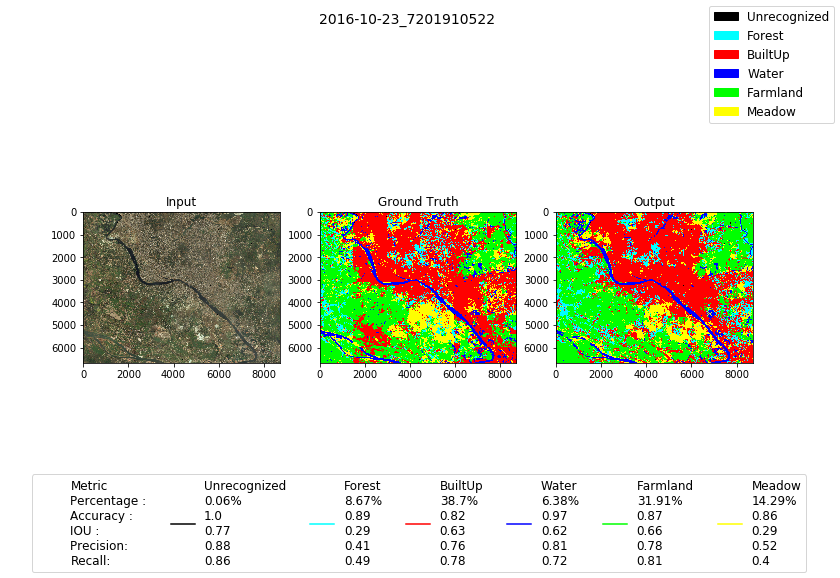

In [15]:
ac = []
io = []
pr = []
rc = []
pe = []
numClass = 6


# Percentage of each classes
percent = percentage(num_of_classes=numClass, target=tar_ind)
for i in range(numClass):
    tp, fp, fn, tn = get_confusion_metrics_score(class_index=i, conf_metric=cf)
    
    acc = accuracy(tp=tp, tn=tn, fp=fp, fn=fn)
    iou_sc = iou_conf(tp=tp, fn=fn, fp=fp)
    prec = precision(tp=tp, fp=fp)
    rec = recall(tp=tp, fn=fn)

    ac.append(round(acc,2))
    io.append(round(iou_sc,2))
    pr.append(round(prec,2))
    rc.append(round(rec,2))
    pe.append(round(percent[i], 2))
    
f, axarr = plt.subplots(1, 3, figsize=(12, 8))
f.suptitle(img.rstrip('.png'), fontsize=14)
           
axarr[0].imshow(org)
axarr[0].title.set_text('Input')

axarr[1].imshow(target)
axarr[1].title.set_text('Ground Truth')

axarr[2].imshow(predict)
axarr[2].title.set_text('Output')

unrecognized = mpatches.Patch(color="#000000", label="Unrecognized")
forest = mpatches.Patch(color='#00FFFF', label='Forest')
builtUp = mpatches.Patch(color='#FF0000', label='BuiltUp')
water = mpatches.Patch(color='#0000FF', label='Water')
farmland = mpatches.Patch(color='#00FF00', label='Farmland')
meadow = mpatches.Patch(color='#FFFF00', label='Meadow')
f.legend(loc='upper right', fontsize='12', handles=[unrecognized, forest, builtUp, water, farmland, meadow])
for i in range (len(ac)):
    if io[i] == 0:
        io[i] = '-'
    if pr[i] == 0:
        pr[i] = '-'
    if rc[i] == 0:
        rc[i] = '-'

axarr[0].plot([], [], color='#FFFFFF', label="Metric\nPercentage :\nAccuracy :\nIOU :\nPrecision: \nRecall:")
axarr[0].plot([], [], color='#000000', label="Unrecognized\n"+str(pe[0])+"%\n"+str(ac[0])+"\n"+str(io[0])+"\n"+str(pr[0])+"\n"+str(rc[0]))
axarr[0].plot([], [], color='#00FFFF', label="Forest\n"+str(pe[1])+"%\n"+str(ac[1])+"\n"+str(io[1])+"\n"+str(pr[1])+"\n"+str(rc[1]))
axarr[0].plot([], [], color='#FF0000', label="BuiltUp\n"+str(pe[2])+"%\n"+str(ac[2])+"\n"+str(io[2])+"\n"+str(pr[2])+"\n"+str(rc[2]))
axarr[0].plot([], [], color='#0000FF', label="Water\n"+str(pe[3])+"%\n"+str(ac[3])+"\n"+str(io[3])+"\n"+str(pr[3])+"\n"+str(rc[3]))
axarr[0].plot([], [], color='#00FF00', label="Farmland\n"+str(pe[4])+"%\n"+str(ac[4])+"\n"+str(io[4])+"\n"+str(pr[4])+"\n"+str(rc[4]))
axarr[0].plot([], [], color='#FFFF00', label="Meadow\n"+str(pe[5])+"%\n"+str(ac[5])+"\n"+str(io[5])+"\n"+str(pr[5])+"\n"+str(rc[5]))
    
f.legend(loc='lower center', bbox_to_anchor=(0.485, 0.00), shadow=False, ncol=10, fontsize='12')
plt.savefig(img, dpi=300)
plt.show()